In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from svhn_utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = svhn(valid=10000, batch_size=50)

Using downloaded and verified file: ./SVHN_data/test_32x32.mat
Using downloaded and verified file: ./SVHN_data/train_32x32.mat
train shape:  (73257, 3, 32, 32)
test shape:  (26032, 3, 32, 32)


Using downloaded and verified file: ./SVHN_data/train_32x32.mat


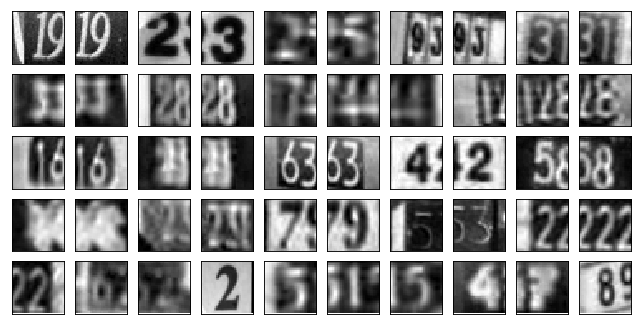

In [3]:
images = svhn_plotdata()
plot_svhn(images, (5, 10))

## Обучение классификатора

In [4]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(512)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def train(epoch, models):
    loss_stats = np.empty((0,4))
    
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
       
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()                
            
            
        if batch_idx % 200 == 0:
            print_stats(models, train_loader, epoch, batch_idx, data, train_size)            
            stats_line = np.array([m._loss.item() for m in models])
            loss_stats = np.vstack([loss_stats, stats_line])          
            
    else:
        batch_idx += 1
        print_stats(models, train_loader, epoch, batch_idx, data, train_size)
        stats_line = np.array([m._loss.item() for m in models])
        loss_stats = np.vstack([loss_stats, stats_line])
       
    epoch_loss = np.mean(loss_stats, axis=0)      
    return epoch_loss
       
        
def print_stats(models, train_loader, epoch, batch_idx, data, train_size):
    line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
    losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
    print(line + losses)
        

In [6]:
models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]

In [7]:
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)
    
    return test_loss, correct_pct

In [8]:
epoch_train_loss = []
epoch_test_loss = []
epoch_test_acc = []

In [9]:
for epoch in range(1, 51):
    for model in models:
        model.train()
    train_loss_val = train(epoch, models)
    epoch_train_loss.append(train_loss_val)
    
    for model in models:
        model.eval()
    test_loss_val, test_acc_val = test(models, valid_loader)
    epoch_test_loss.append(test_loss_val)
    epoch_test_acc.append(test_acc_val)
    

Train Epoch: 1 [0/63257 (0%)]	Losses 0: 2.310274 1: 2.307318 2: 2.308679 3: 2.304830
Train Epoch: 1 [10000/63257 (16%)]	Losses 0: 1.753762 1: 1.808581 2: 1.788823 3: 1.811128
Train Epoch: 1 [20000/63257 (32%)]	Losses 0: 1.327735 1: 1.317818 2: 1.333717 3: 1.337528
Train Epoch: 1 [30000/63257 (47%)]	Losses 0: 0.969170 1: 0.949884 2: 0.984660 3: 0.941711
Train Epoch: 1 [40000/63257 (63%)]	Losses 0: 1.286733 1: 1.277089 2: 1.275308 3: 1.292307
Train Epoch: 1 [50000/63257 (79%)]	Losses 0: 0.884501 1: 1.034552 2: 0.913778 3: 1.019939
Train Epoch: 1 [60000/63257 (95%)]	Losses 0: 0.956674 1: 0.945014 2: 0.953256 3: 0.986835
Train Epoch: 1 [8862/63257 (100%)]	Losses 0: 0.801140 1: 1.371750 2: 0.739506 3: 1.307421
Test set:
0: Loss: 0.8782	Accuracy: 7321/10000 (73%)
1: Loss: 0.8992	Accuracy: 7277/10000 (72%)
2: Loss: 0.8989	Accuracy: 7213/10000 (72%)
3: Loss: 0.9002	Accuracy: 7267/10000 (72%)

Train Epoch: 2 [0/63257 (0%)]	Losses 0: 1.020692 1: 1.005908 2: 1.059106 3: 0.989889
Train Epoch: 2 [1

Train Epoch: 10 [20000/63257 (32%)]	Losses 0: 0.370814 1: 0.385875 2: 0.412221 3: 0.420965
Train Epoch: 10 [30000/63257 (47%)]	Losses 0: 0.542102 1: 0.633063 2: 0.535962 3: 0.664521
Train Epoch: 10 [40000/63257 (63%)]	Losses 0: 0.437912 1: 0.655484 2: 0.361727 3: 0.580855
Train Epoch: 10 [50000/63257 (79%)]	Losses 0: 0.622027 1: 0.721606 2: 0.653875 3: 0.750797
Train Epoch: 10 [60000/63257 (95%)]	Losses 0: 0.624031 1: 0.748191 2: 0.577277 3: 0.693624
Train Epoch: 10 [8862/63257 (100%)]	Losses 0: 1.304847 1: 1.437884 2: 1.489406 3: 0.971078
Test set:
0: Loss: 0.5442	Accuracy: 8409/10000 (84%)
1: Loss: 0.5292	Accuracy: 8398/10000 (83%)
2: Loss: 0.5570	Accuracy: 8398/10000 (83%)
3: Loss: 0.5328	Accuracy: 8414/10000 (84%)

Train Epoch: 11 [0/63257 (0%)]	Losses 0: 0.612004 1: 0.842160 2: 0.674266 3: 0.845552
Train Epoch: 11 [10000/63257 (16%)]	Losses 0: 0.300229 1: 0.352552 2: 0.266765 3: 0.420973
Train Epoch: 11 [20000/63257 (32%)]	Losses 0: 0.530915 1: 0.543909 2: 0.565275 3: 0.638463
Tra

Train Epoch: 19 [30000/63257 (47%)]	Losses 0: 0.370391 1: 0.493405 2: 0.343415 3: 0.434106
Train Epoch: 19 [40000/63257 (63%)]	Losses 0: 0.332163 1: 0.342829 2: 0.313419 3: 0.337536
Train Epoch: 19 [50000/63257 (79%)]	Losses 0: 0.112732 1: 0.324317 2: 0.133771 3: 0.376582
Train Epoch: 19 [60000/63257 (95%)]	Losses 0: 0.162606 1: 0.358598 2: 0.216984 3: 0.402094
Train Epoch: 19 [8862/63257 (100%)]	Losses 0: 0.035364 1: 1.152802 2: 0.029614 3: 0.739851
Test set:
0: Loss: 0.5458	Accuracy: 8567/10000 (85%)
1: Loss: 0.4981	Accuracy: 8557/10000 (85%)
2: Loss: 0.5911	Accuracy: 8446/10000 (84%)
3: Loss: 0.4956	Accuracy: 8521/10000 (85%)

Train Epoch: 20 [0/63257 (0%)]	Losses 0: 0.156613 1: 0.332686 2: 0.190439 3: 0.381122
Train Epoch: 20 [10000/63257 (16%)]	Losses 0: 0.146845 1: 0.236470 2: 0.172701 3: 0.190140
Train Epoch: 20 [20000/63257 (32%)]	Losses 0: 0.270684 1: 0.387085 2: 0.338047 3: 0.322534
Train Epoch: 20 [30000/63257 (47%)]	Losses 0: 0.384503 1: 0.600934 2: 0.611881 3: 0.410871
Tra

Train Epoch: 28 [40000/63257 (63%)]	Losses 0: 0.146004 1: 0.292808 2: 0.167043 3: 0.280300
Train Epoch: 28 [50000/63257 (79%)]	Losses 0: 0.237423 1: 0.335226 2: 0.176769 3: 0.274210
Train Epoch: 28 [60000/63257 (95%)]	Losses 0: 0.147966 1: 0.184695 2: 0.055306 3: 0.128144
Train Epoch: 28 [8862/63257 (100%)]	Losses 0: 0.001285 1: 0.105707 2: 0.003270 3: 0.282645
Test set:
0: Loss: 0.6007	Accuracy: 8595/10000 (85%)
1: Loss: 0.4976	Accuracy: 8620/10000 (86%)
2: Loss: 0.6055	Accuracy: 8607/10000 (86%)
3: Loss: 0.4911	Accuracy: 8595/10000 (85%)

Train Epoch: 29 [0/63257 (0%)]	Losses 0: 0.056171 1: 0.274542 2: 0.067859 3: 0.258714
Train Epoch: 29 [10000/63257 (16%)]	Losses 0: 0.086967 1: 0.191950 2: 0.088822 3: 0.183243
Train Epoch: 29 [20000/63257 (32%)]	Losses 0: 0.099171 1: 0.296481 2: 0.153457 3: 0.314766
Train Epoch: 29 [30000/63257 (47%)]	Losses 0: 0.142313 1: 0.299372 2: 0.163961 3: 0.391322
Train Epoch: 29 [40000/63257 (63%)]	Losses 0: 0.455933 1: 0.411841 2: 0.395176 3: 0.505772
Tra

Train Epoch: 37 [50000/63257 (79%)]	Losses 0: 0.097775 1: 0.157519 2: 0.138491 3: 0.341891
Train Epoch: 37 [60000/63257 (95%)]	Losses 0: 0.055006 1: 0.086322 2: 0.025392 3: 0.088369
Train Epoch: 37 [8862/63257 (100%)]	Losses 0: 0.125261 1: 0.177988 2: 0.063517 3: 0.187013
Test set:
0: Loss: 0.6932	Accuracy: 8591/10000 (85%)
1: Loss: 0.5080	Accuracy: 8681/10000 (86%)
2: Loss: 0.7019	Accuracy: 8568/10000 (85%)
3: Loss: 0.5256	Accuracy: 8580/10000 (85%)

Train Epoch: 38 [0/63257 (0%)]	Losses 0: 0.030915 1: 0.172239 2: 0.045835 3: 0.158496
Train Epoch: 38 [10000/63257 (16%)]	Losses 0: 0.091886 1: 0.197572 2: 0.080089 3: 0.135484
Train Epoch: 38 [20000/63257 (32%)]	Losses 0: 0.073394 1: 0.193573 2: 0.093495 3: 0.271173
Train Epoch: 38 [30000/63257 (47%)]	Losses 0: 0.207000 1: 0.244693 2: 0.111286 3: 0.299060
Train Epoch: 38 [40000/63257 (63%)]	Losses 0: 0.053541 1: 0.178446 2: 0.056787 3: 0.158953
Train Epoch: 38 [50000/63257 (79%)]	Losses 0: 0.106296 1: 0.238303 2: 0.118538 3: 0.214201
Tra

Train Epoch: 46 [60000/63257 (95%)]	Losses 0: 0.044607 1: 0.148827 2: 0.036114 3: 0.156035
Train Epoch: 46 [8862/63257 (100%)]	Losses 0: 0.038220 1: 0.152256 2: 0.003804 3: 0.585956
Test set:
0: Loss: 0.7758	Accuracy: 8622/10000 (86%)
1: Loss: 0.5164	Accuracy: 8696/10000 (86%)
2: Loss: 0.8061	Accuracy: 8539/10000 (85%)
3: Loss: 0.5230	Accuracy: 8662/10000 (86%)

Train Epoch: 47 [0/63257 (0%)]	Losses 0: 0.057832 1: 0.093147 2: 0.028708 3: 0.147142
Train Epoch: 47 [10000/63257 (16%)]	Losses 0: 0.057694 1: 0.086773 2: 0.200645 3: 0.141599
Train Epoch: 47 [20000/63257 (32%)]	Losses 0: 0.098758 1: 0.086496 2: 0.014706 3: 0.070656
Train Epoch: 47 [30000/63257 (47%)]	Losses 0: 0.033932 1: 0.098487 2: 0.086658 3: 0.106826
Train Epoch: 47 [40000/63257 (63%)]	Losses 0: 0.115201 1: 0.121073 2: 0.041488 3: 0.071352
Train Epoch: 47 [50000/63257 (79%)]	Losses 0: 0.015615 1: 0.163142 2: 0.071499 3: 0.131185
Train Epoch: 47 [60000/63257 (95%)]	Losses 0: 0.143553 1: 0.392316 2: 0.027064 3: 0.368356
Tra

In [10]:
final_train_loss = np.array(epoch_train_loss)
final_test_loss = np.array(epoch_test_loss)
final_test_acc = np.array(epoch_test_acc)

## Вывод результатов

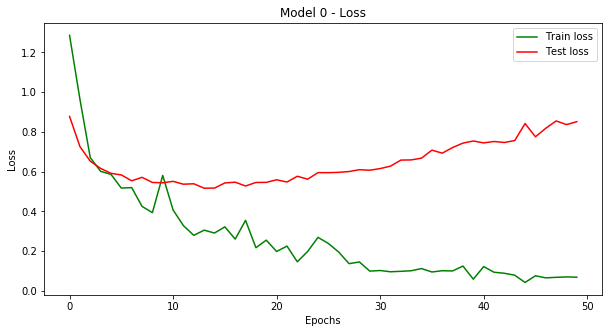

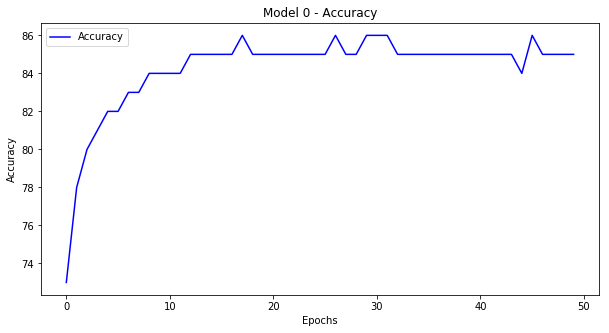

In [11]:
plot_results(0, final_train_loss, final_test_loss, final_test_acc)

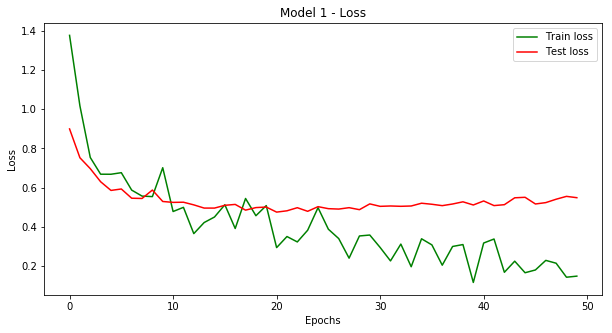

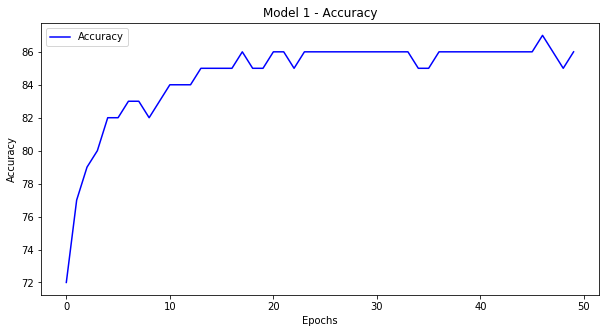

In [12]:
plot_results(1, final_train_loss, final_test_loss, final_test_acc)

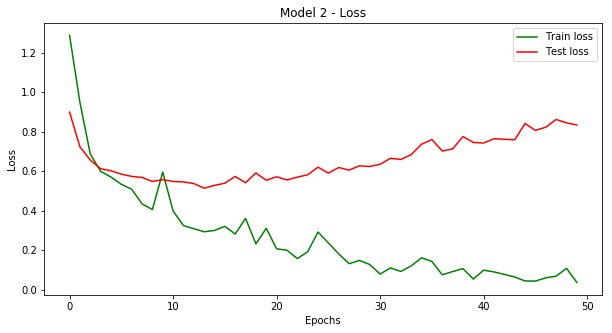

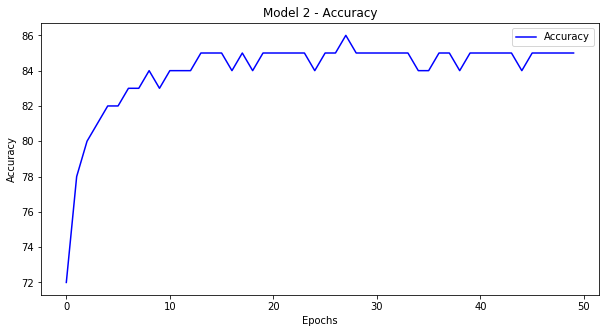

In [13]:
plot_results(2, final_train_loss, final_test_loss, final_test_acc)

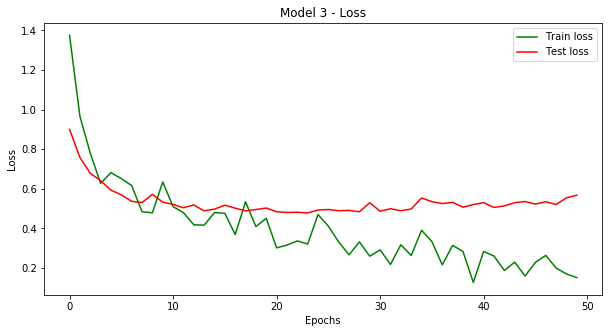

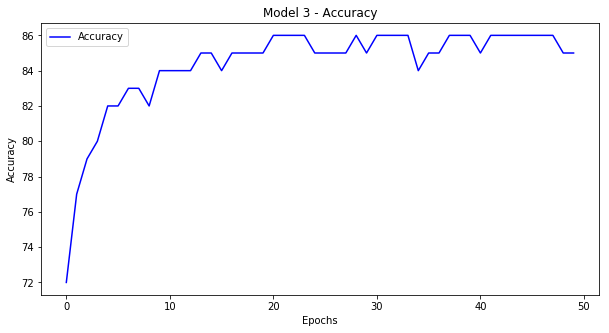

In [14]:
plot_results(3, final_train_loss, final_test_loss, final_test_acc)

Модели 0 и 2 демонстрируют явные признаки переобучения. В моделях 1 и 3 ситуация лучше, можно сделать вывод, что использование Batch Normalization в данных моделях помогает бороться с переобучением.